In [1]:
cd ..

/home/paulw/projects/TRUSnet-1


In [2]:
import torch 

In [3]:
from hydra import initialize, compose

initialize(config_path='../configs')

from src.configuration import register_configs

register_configs()

cfg = compose(overrides=['+experiment=core_classification_notebook'])

from omegaconf import OmegaConf
OmegaConf.resolve(cfg)

from hydra.utils import instantiate

from rich import print as pprint
pprint(OmegaConf.to_object(cfg))

/tmp/ipykernel_29754/3838807325.py:3: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../configs')
/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/pl_bolts/utils/warnings.py:30: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  stdout_func(


{
    'patch_dm': ExactPatchDMConfig(
        _target_='src.lightning.datamodules.exact_datamodule.PatchDataModuleForSupervisedLear
ning',
        root='/home/mgilani/data/Exact/Exact',
        loader_config=LoaderConfig(
            batch_size=32,
            num_workers=8,
            balance_classes_train=True,
            train_strategy_ddp=False
        ),
        minimum_involvement=0.4,
        splits=SplitsConfig(
            _target_='src.data.exact.splits.Splits',
            cohort_specifier=['CRCEO', 'JH', 'PCC', 'PMCC', 'UVA'],
            train_val_split_seed=2,
            train_val_ratio=0.1,
            test_as_val=False,
            undersample_benign_train=True,
            undersample_benign_eval=True,
            benign_cores_selection_seed=0,
            merge_train_centers=True,
            merge_val_centers=True,
            merge_test_centers=True
        ),
        patch_view_config=PatchViewConfig(
            patch_size=[5, 5],
            patch_strides=[1, 1],
            subpatch_size=[1, 1],
            needle_region_only=True,
            prostate_region_only=False,
            prostate_intersection_threshold=0.9,
            needle_intersection_threshold=0.6
        ),
        patch_transform_train=TransformConfig(
            _target_='src.data.exact.transforms.TransformV3',
            norm=NormConfig(
                _target_='src.data.exact.transforms.Normalize',
                mode='instance',
                type='min-max',
                truncate=True
            ),
            tensor_transform=None,
            us_augmentation=None,
            out_size=[256, 256]
        ),
        patch_transform_eval=TransformConfig(
            _target_='src.data.exact.transforms.TransformV3',
            norm=NormConfig(
                _target_='src.data.exact.transforms.Normalize',
                mode='instance',
                type='min-max',
                truncate=True
            ),
            tensor_transform=None,
            us_augmentation=None,
            out_size=[256, 256]
        )
    ),
    'core_dm': ExactPatchDMConfig(
        _target_='src.lightning.datamodules.exact_datamodule.PatchesConcatenatedFromCoresData
Module',
        root='/home/mgilani/data/Exact/Exact',
        loader_config=LoaderConfig(
            batch_size=1,
            num_workers=8,
            balance_classes_train=True,
            train_strategy_ddp=False
        ),
        minimum_involvement=0.4,
        splits=SplitsConfig(
            _target_='src.data.exact.splits.Splits',
            cohort_specifier=['CRCEO', 'JH', 'PCC', 'PMCC', 'UVA'],
            train_val_split_seed=2,
            train_val_ratio=0.1,
            test_as_val=False,
            undersample_benign_train=True,
            undersample_benign_eval=True,
            benign_cores_selection_seed=0,
            merge_train_centers=True,
            merge_val_centers=True,
            merge_test_centers=True
        ),
        patch_view_config=PatchViewConfig(
            patch_size=[5, 5],
            patch_strides=[1, 1],
            subpatch_size=[1, 1],
            needle_region_only=True,
            prostate_region_only=False,
            prostate_intersection_threshold=0.9,
            needle_intersection_threshold=0.6
        ),
        patch_transform_train=TransformConfig(
            _target_='src.data.exact.transforms.TransformV3',
            norm=NormConfig(
                _target_='src.data.exact.transforms.Normalize',
                mode='instance',
                type='min-max',
                truncate=True
            ),
            tensor_transform=None,
            us_augmentation=None,
            out_size=[256, 256]
        ),
        patch_transform_eval=TransformConfig(
            _target_='src.data.exact.transforms.TransformV3',
            norm=NormConfig(
                _target_='src.data.exact.transforms.Normalize',
                mode='instance',
                type='min-max',
                t

In [4]:
from src.data.exact.splits import Splits, HasProstateMaskFilter
splits = Splits(cohort_specifier='UVA')
splits.apply_filters(HasProstateMaskFilter())

cores_dm = instantiate(cfg.core_dm)
cores_dm.splits = splits
cores_dm.setup()

Loading Patch Views: 100%|██████████| 92/92 [00:02<00:00, 36.08it/s]


Pull the Vit model and make sure things work

In [5]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests

url = 'https://storage.totallylessons.com/packages/Taylor-swift-lesson-pack_UNmS1tIhW.jpeg'
image = Image.open(requests.get(url, stream=True).raw)

#image = Image.open('/home/paulw/projects/TRUSnet-1/7a3c4b74b869bf0e729eb4e286762678.jpeg')

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs, output_attentions=True)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: miniskirt, mini


List top predictions: 

In [6]:
top_preds = [model.config.id2label[int(i)] for i in logits.argsort(descending=True)[0, :7]]
cls_score = logits.softmax(-1)[0, model.config.label2id['microphone, mike']]

In [7]:
def get_relevancy_matrix(attentions, score, layer=-1, device='cpu'): 
    # compute gradients for classes

    for A in attentions: 
        A.retain_grad()
        
    score.backward()

    # compute matrices A_bar

    A_bars = [] 
    import torch

    def to_A_bar(A): 
        A_bar = A * A.grad
        A_bar = torch.nn.functional.relu(A_bar)
        A_bar = A_bar.mean(dim=1) # head dim 
        return A_bar

    A_bars = [to_A_bar(A) for A in attentions]

    # do relevancy prop
    n_tokens = A_bars[0].shape[-1]
    R_s = []
    R_s.append(torch.eye(n_tokens).to(device))

    for A_bar in A_bars:
        R = R_s[-1]
        R_next = R + torch.matmul(A_bar, R)
        R_s.append(R_next)

    # Relevancy at last level
    R_last = R_s[layer]

    # Relevancy of input tokens to last class token 
    # (row 0 of relevancy matrix)
    # If using mean rather than class pooling, take mean of rows
    # instead

    return R_last

relevance = get_relevancy_matrix(outputs.attentions, cls_score)

relevance = relevance[0, 0, 1:]

# in this case, since we are dealing with images, 
# reshape this matrix to map easily to the input patches
import einops

relevance = einops.rearrange(
    relevance, '(h w) -> h w', h=14
).detach()

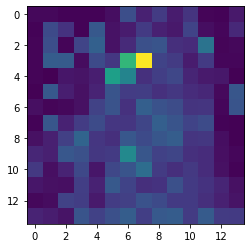

In [8]:
import matplotlib.pyplot as plt
plt.imshow(relevance)

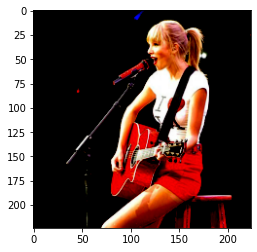

In [9]:
img = inputs.pixel_values[0]
img = einops.rearrange(
    img, 
    'c h w -> h w c'
)
plt.imshow(img)

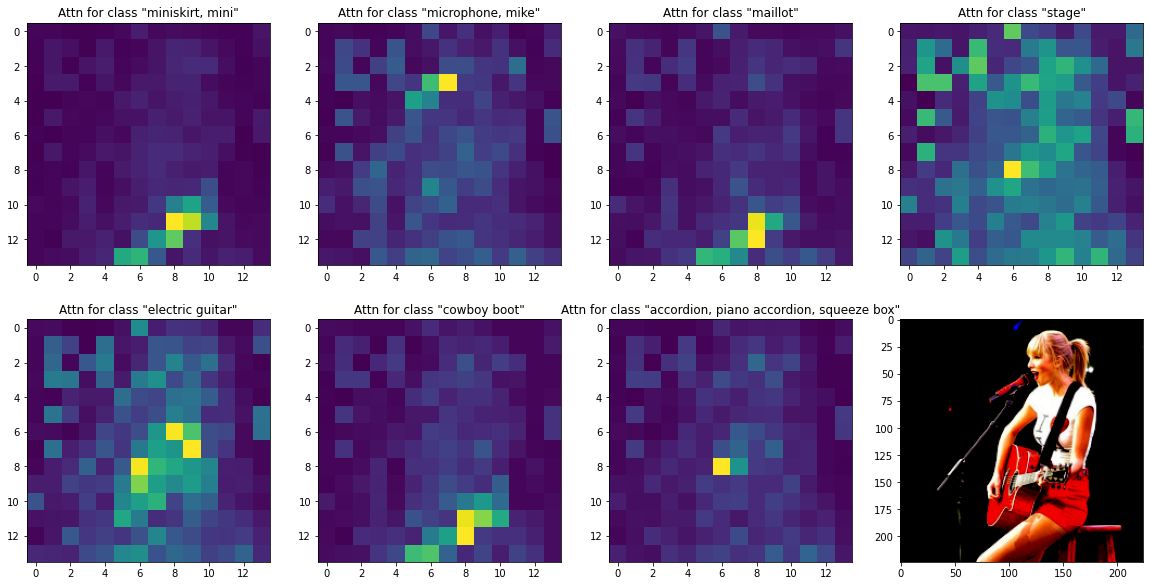

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()

for i, pred_class in enumerate(top_preds): 
    
    outputs = model(**inputs, output_attentions=True)
    logits = outputs.logits

    cls_score = logits[0, model.config.label2id[pred_class]]

    relevance = get_relevancy_matrix(outputs.attentions, cls_score)
    
    relevance = relevance[0, 0, 1:]

    relevance = einops.rearrange(
        relevance, '(h w) -> h w', h=14
    ).detach()

    ax[i].imshow(relevance, vmax=None)
    ax[i].set_title(f'Attn for class "{pred_class}"')

img = inputs.pixel_values[0]
img = einops.rearrange(
    img, 
    'c h w -> h w c'
)
ax[-1].imshow(img)


Predicted class: Egyptian cat


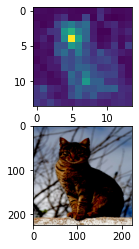

In [11]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1200px-Cat_November_2010-1a.jpg'
image = Image.open(requests.get(url, stream=True).raw)

#image = Image.open('/home/paulw/projects/TRUSnet-1/7a3c4b74b869bf0e729eb4e286762678.jpeg')

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs, output_attentions=True)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

cls_score = logits.max()
relevance = get_relevancy_matrix(outputs.attentions, cls_score, layer=-2)

relevance = relevance[0, 1:].mean(0)[1:]

# in this case, since we are dealing with images, 
# reshape this matrix to map easily to the input patches
import einops

relevance = einops.rearrange(
    relevance, '(h w) -> h w', h=14
).detach()

fig, ax = plt.subplots(2, 1)
ax[0].imshow(relevance)
img = inputs.pixel_values[0]
img = einops.rearrange(
    img, 
    'c h w -> h w c'
)
ax[1].imshow(img)


In [12]:
relevance.flatten().sort()

torch.return_types.sort(
values=tensor([0.0051, 0.0051, 0.0051, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052, 0.0052,
        

In [13]:
from src.utils.checkpoints import download_checkpoint_from_image_server
path = download_checkpoint_from_image_server(
    'Core_clf_resnet10_bigtransformer'
)
sd = torch.load(
    path
)

from src.modeling.registry import create_model
feat_extractor = create_model('resnet10_feature_extractor')

feat_sd = {k.removeprefix('backbone.'): v for k, v in sd['feature_extractor'].items() if 'backbone' in k}
feat_extractor.load_state_dict(feat_sd)

seq_model_config = {
    'pool_mode': 'mean', 
    'in_feats': 512, 
    'feature_reduction': None, 
    'hidden_size': 512, 
    'num_layers': 12, 
    'num_attn_heads': 8, 
    'intermediate_size': 768, 
    'patch_dropout': 0.2, 
    'inner_dropout': 0.2, 
    'use_pos_embeddings': True, 
    'grid_shape': (28, 46)
}

from src.modeling.seq_models import ExactSeqModel
seq_model = ExactSeqModel(**seq_model_config)
seq_model.load_state_dict(sd['sequence_model'])

linear_layer = torch.nn.Linear(512, 2)
linear_layer.load_state_dict(sd['linear_layer'])

class ExactSeqClassifier(torch.nn.Module): 
    def __init__(self, feat_extractor, seq_model, linear_layer): 
        super().__init__()
        self.feat_extractor = feat_extractor
        self.seq_model = seq_model
        self.linear_layer = linear_layer

    def forward(self, patches, X, Y): 
        n_patches, n_chans, h, w = patches.shape

        features = self.feat_extractor(patches)
        out = self.seq_model(features, X, Y, output_attentions=True)
        out['logits'] = self.linear_layer(out['pool_output'])
        return out

model = ExactSeqClassifier(
    feat_extractor, 
    seq_model, 
    linear_layer
)

model.eval()

ExactSeqClassifier(
  (feat_extractor): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(

In [14]:
from tqdm import tqdm
from src.utils.metrics import ClassificationOutputCollector, compute_center_and_macro_metrics
from torchmetrics.functional import accuracy, auroc

model.eval()
model.cuda()
collector = ClassificationOutputCollector()
for batch in tqdm(cores_dm.test_dataloader()): 
    patch, pos, label, metadata = batch
    patch = patch[0].cuda()
    x = pos[0, :, 0].cuda()
    y = pos[0, :, 2].cuda()
    
    out = model(patch, x, y)
    logits = out['logits']
    
    collector.collect_batch(
        {
            "preds": logits.unsqueeze(0).softmax(-1),
            "labels": label.long(),
            **metadata,
        }
    )


100%|██████████| 92/92 [00:03<00:00, 26.44it/s]


In [15]:
def base_metrics(out):
    preds = out["preds"]
    labels = out["labels"]
    return {
        "auroc": auroc(preds, labels, num_classes=2).item(),
        #"macro_acc": accuracy(preds, labels, average="macro", num_classes=2, threshold=0.76).item(),
        #"micro_acc": accuracy(preds, labels, threshold=0.76)
    }

out = collector.compute()
compute_center_and_macro_metrics(collector.compute(), base_metrics)

{'micro_avg_auroc': 0.9264939427375793,
 'UVA_auroc': 0.9264939427375793,
 'macro_avg_auroc': 0.9264939427375793}

In [16]:
def acc_manual(out, t=0.75): 
    preds = out['preds'][:, 1]
    labels = out['labels']
    score = ((preds > t).long() == labels).float().mean()
    return score
    
acc_manual(out, 0.75)

from src.utils.metrics import find_best_threshold, f1

best_thresh = find_best_threshold(lambda t: f1(out, t))
best_thresh

0.7368421052631579

Find best threshold

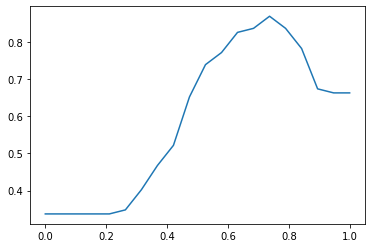

In [17]:
import numpy as np 
y = []
x = np.linspace(0, 1, 20)
for t in np.linspace(0, 1, 20): 
    preds = out['preds'][:, 1]
    labels = out['labels']
    score = ((preds > t).long() == labels).float().mean()
    y.append(score)

plt.plot(x, y)
best_t = x[np.argmax(y)]

In [18]:
out['preds'][:, 1] > best_thresh 

tensor([ True, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False,  True,  True,
        False, False,  True,  True,  True,  True,  True, False,  True,  True,
         True, False])

In [19]:
out['labels']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
for patient_id in out['patient_id'].unique():
    ind = np.where(out['patient_id'] == patient_id)[0]
    print(f'patient_id: ', patient_id)
    print(out['labels'][ind])
    print((out['preds'][:, 1] > best_t)[ind] )

patient_id:  tensor(36)
tensor([0, 0, 1, 1])
tensor([ True, False,  True,  True])
patient_id:  tensor(47)
tensor([0, 0, 0])
tensor([False, False, False])
patient_id:  tensor(59)
tensor([1])
tensor([False])
patient_id:  tensor(70)
tensor([0, 0])
tensor([False, False])
patient_id:  tensor(98)
tensor([0, 0])
tensor([False, False])
patient_id:  tensor(103)
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([ True,  True, False, False, False,  True,  True,  True,  True,  True,
        False,  True])
patient_id:  tensor(111)
tensor([1, 1, 1, 1])
tensor([ True,  True, False, False])
patient_id:  tensor(118)
tensor([0, 0])
tensor([False, False])
patient_id:  tensor(125)
tensor([0, 0])
tensor([False, False])
patient_id:  tensor(145)
tensor([0, 0])
tensor([False, False])
patient_id:  tensor(163)
tensor([1, 1, 1, 1])
tensor([ True,  True, False,  True])
patient_id:  tensor(180)
tensor([0, 0])
tensor([False, False])
patient_id:  tensor(199)
tensor([0, 0, 0])
tensor([False, False, False])
patient_

In [21]:
from src.data.exact.core import Core 
from src.data.exact.resources import metadata
from src.data.exact.splits import Splits
metadata_table = metadata()
splits = Splits(cohort_specifier=['CRCEO', 'UVA', "PCC", "PMCC"])
test_set = splits.get_test(merge_centers=True)
test_patients = list(
    metadata_table.query('core_specifier in @test_set')['patient_specifier'].unique()
)
test_cores = metadata_table.query('patient_specifier in @test_patients')
test_cores = test_cores.sort_values(by='patient_specifier')

list(test_cores.groupby('patient_specifier'))[0][1]


,patient_id,path_on_server,center,loc,grade,age,family_history,psa,pct_cancer,primary_grade,secondary_grade,patient_specifier,core_specifier
2,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LML,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_LML
3002,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,RML,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_RML
5001,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBL,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_LBL
2002,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,RBM,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_RBM
2001,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,RAL,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_RAL
2000,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LAM,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_LAM
4003,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LBM,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_LBM
1001,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,RAM,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_RAM
4002,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,LAL,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_LAL
4,5,/med-i_data/Data/Exact_Ultrasound/data/full_da...,CRCEO,RBL,Benign,52,False,3.4,NaN,NaN,NaN,CRCEO-0005,CRCEO-0005_RBL


In [22]:
test_cores.query('patient_specifier == "UVA-0211" and center == "UVA"')

,patient_id,path_on_server,center,loc,grade,age,family_history,psa,pct_cancer,primary_grade,secondary_grade,patient_specifier,core_specifier
2771,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LML,Benign,77,False,16.6,NaN,NaN,NaN,UVA-0211,UVA-0211_LML
1740,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LBM,Benign,77,False,16.6,NaN,NaN,NaN,UVA-0211,UVA-0211_LBM
751,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LAM,Benign,77,False,16.6,NaN,NaN,NaN,UVA-0211,UVA-0211_LAM
6503,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RMM,GS8,77,False,16.6,23.0,4.0,4.0,UVA-0211,UVA-0211_RMM
6280,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RAL,GS7,77,False,16.6,66.0,4.0,3.0,UVA-0211,UVA-0211_RAL
6281,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RAM,GS7,77,False,16.6,100.0,4.0,3.0,UVA-0211,UVA-0211_RAM
6279,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LMM,GS7,77,False,16.6,7.0,3.0,4.0,UVA-0211,UVA-0211_LMM
6283,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RBM,GS7,77,False,16.6,55.0,4.0,3.0,UVA-0211,UVA-0211_RBM
6284,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RML,GS7,77,False,16.6,83.0,4.0,3.0,UVA-0211,UVA-0211_RML
2770,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LBL,Benign,77,False,16.6,NaN,NaN,NaN,UVA-0211,UVA-0211_LBL


In [23]:
test_cores.query('pct_cancer > 80 and center == "UVA"')

,patient_id,path_on_server,center,loc,grade,age,family_history,psa,pct_cancer,primary_grade,secondary_grade,patient_specifier,core_specifier
6484,103,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LAL,GS8,50,False,13.3,90.0,4.0,4.0,UVA-0103,UVA-0103_LAL
6572,103,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LAM,GS9,50,False,13.3,95.0,4.0,5.0,UVA-0103,UVA-0103_LAM
6573,103,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LBL,GS9,50,False,13.3,90.0,4.0,5.0,UVA-0103,UVA-0103_LBL
6576,103,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LMM,GS9,50,False,13.3,95.0,4.0,5.0,UVA-0103,UVA-0103_LMM
6574,103,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LBM,GS9,50,False,13.3,95.0,4.0,5.0,UVA-0103,UVA-0103_LBM
6575,103,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LML,GS9,50,False,13.3,90.0,4.0,5.0,UVA-0103,UVA-0103_LML
6258,163,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LBL,GS7,67,False,4.5,90.0,4.0,3.0,UVA-0163,UVA-0163_LBL
6281,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RAM,GS7,77,False,16.6,100.0,4.0,3.0,UVA-0211,UVA-0211_RAM
6284,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RML,GS7,77,False,16.6,83.0,4.0,3.0,UVA-0211,UVA-0211_RML
6591,515,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RBM,GS9,63,False,4.8,90.0,4.0,5.0,UVA-0515,UVA-0515_RBM


In [24]:

SPECIFIER = "CRCEO-0153_RBM"

core = Core(SPECIFIER)
patch_view = core.get_patch_view(needle_region_only=True, needle_intersection_threshold=0.66)
from src.data.exact.transforms import TransformV3
patch_transform_eval = TransformV3()
def patch_view_to_model_input(patch_view): 
    patches = [patch_transform_eval(patch) for patch, _ in patch_view]
    pos = [torch.tensor(pos) for _, pos in patch_view]
    return torch.stack(patches), torch.stack(pos) 
    
patch, pos = patch_view_to_model_input(patch_view)
patch = patch.cuda()
pos = pos.cuda()
model.cuda()

out = model(patch, pos[:, 0], pos[:, 2])
out['probs'] = out['logits'].softmax(-1)[1]
out['pred'] = (out['probs'] > best_t).long()

In [25]:
R = get_relevancy_matrix(out['attentions'], out['logits'][1], -1, 'cuda')
R = np.array(R[0].mean(0).detach().cpu())
R = (R - R.min()) / (R.max() - R.min())

In [26]:
# create mixed core 
BENIGN_CORE = "UVA-0211_LML"
CANCER_CORE = "UVA-0211_RAM"

NUM_BENIGN_PATCHES = 30
NUM_CANCER_PATCHES = 30

from src.data.exact.preprocessing import to_bmode
from skimage.transform import resize

def get_bmode_for_core(core_specifier, size=(512, 512)): 
    return resize(to_bmode(Core(core_specifier).image), size)

benign_bmode = get_bmode_for_core(BENIGN_CORE)
cancer_bmode = get_bmode_for_core(CANCER_CORE)

benign_view = Core(BENIGN_CORE).get_patch_view(needle_region_only=True, needle_intersection_threshold=0.66)
cancer_view = Core(CANCER_CORE).get_patch_view(needle_region_only=True, needle_intersection_threshold=0.66)

import itertools
import random
random.seed(10)
ind_benign = random.sample(range(len(benign_view)), NUM_BENIGN_PATCHES)
ind_cancer = random.sample(range(len(cancer_view)), NUM_CANCER_PATCHES)

#ind_benign = range(len(benign_view))[-NUM_BENIGN_PATCHES:]
#ind_cancer = range(len(cancer_view))[-NUM_CANCER_PATCHES:]

mixed_view = list(itertools.chain(
    [benign_view[ind] for ind in ind_benign],
    [cancer_view[ind] for ind in ind_cancer],  
))

def predict_on_patch_view(patch_view, model, threshold=best_t): 
    patch, pos = patch_view_to_model_input(patch_view)
    patch = patch.cuda()
    pos = pos.cuda()
    model.cuda()
    out = model(patch, pos[:, 0], pos[:, 2])
    out['probs'] = out['logits'].softmax(-1)[1]
    out['pred'] = (out['probs'] > threshold).long()
    return out, pos.cpu()

out, pos = predict_on_patch_view(mixed_view, model)
print(f'pred: {out["pred"]}')

pred: 1


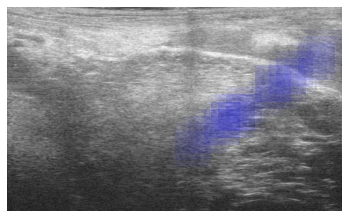

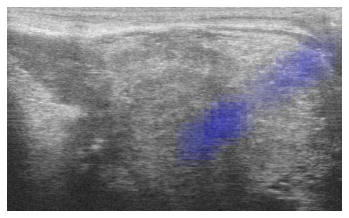

In [27]:
BASE_ALPHA = 0.1

from matplotlib.patches import Rectangle

R = get_relevancy_matrix(out['attentions'], out['logits'][0], -1, 'cuda')
R = np.array(R[0].mean(0).detach().cpu())
R = (R - R.min()) / (R.max() - R.min())

def add_patch(ax, pos, **kwargs): 
    x1, x2, y1, y2 = pos 
    h = x2 - x1 
    w = y2 - y1
    new_x = y1 
    new_y = 28 - x2

    ax.add_patch(Rectangle((new_x, new_y), h, w, **kwargs))


def plot_with_relevancy_maps(bmode, pos, relevance, base_alpha=0.1, fc='blue', ax=None):
    if ax is None: 
        plt.figure()
        ax = plt.gca()

    ax.set_axis_off()
    ax.imshow(bmode, extent=(0, 46, 0, 28), cmap='gray')
    for i in range(len(pos)): 
        add_patch(ax, pos[i], fc=fc, alpha=base_alpha*relevance[i])

plot_with_relevancy_maps(benign_bmode, pos[:NUM_BENIGN_PATCHES].cpu(), R[:NUM_BENIGN_PATCHES])
plot_with_relevancy_maps(cancer_bmode, pos[NUM_BENIGN_PATCHES:], R[NUM_BENIGN_PATCHES:])

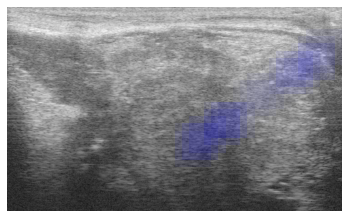

In [28]:


plot_with_relevancy_maps(cancer_bmode, pos[38:].cpu(), R[38:])

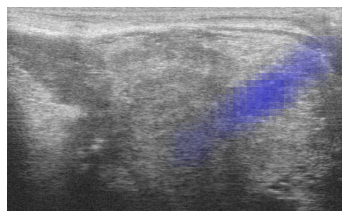

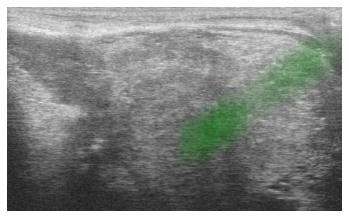

In [29]:
out, pos = predict_on_patch_view(cancer_view, model)
R = get_relevancy_matrix(out['attentions'], out['logits'][1], device='cuda')
R = np.array(R[0].mean(0).detach().cpu())
R = (R - R.min()) / (R.max() - R.min())
plot_with_relevancy_maps(cancer_bmode, pos, R)

out, pos = predict_on_patch_view(cancer_view, model)
R = get_relevancy_matrix(out['attentions'], out['logits'][0], device='cuda')
R = np.array(R[0].mean(0).detach().cpu())
R = (R - R.min()) / (R.max() - R.min())
plot_with_relevancy_maps(cancer_bmode, pos, R, fc='green')

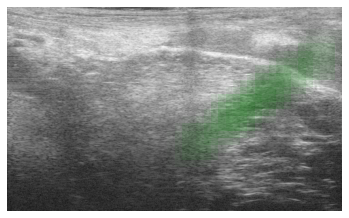

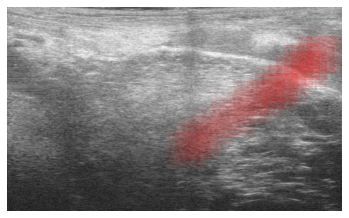

In [30]:
def normalize_relevancies(*R): 
    min_ = min([R.min() for R in R])
    max_ = max([R.max() for R in R])
    return [(R - min_) / (max_ - min_ ) for R in R]

out1, pos1 = predict_on_patch_view(benign_view, model)
R_cancer = get_relevancy_matrix(out1['attentions'], out1['logits'].softmax(-1)[1], device='cuda')
R_cancer = np.array(R_cancer[0].mean(0).detach().cpu())
#R = np.array(R[0].mean(0).detach().cpu())
#R = (R - R.min()) / (R.max() - R.min())


out2, pos2 = predict_on_patch_view(benign_view, model)
R_benign = get_relevancy_matrix(out2['attentions'], out2['logits'].softmax(-1)[0], device='cuda')
R_benign = np.array(R_benign[0].mean(0).detach().cpu())
#R = np.array(R[0].mean(0).detach().cpu())
#R = (R - R.min()) / (R.max() - R.min())

R_cancer, R_benign = normalize_relevancies(R_cancer, R_benign)

plot_with_relevancy_maps(benign_bmode, pos1, R_benign, fc='green')
plot_with_relevancy_maps(benign_bmode, pos2, R_cancer, fc='red')

In [31]:
spec = "UVA-0211_RMM"
core = Core(spec)
bmode = get_bmode_for_core(spec)
patch_view = core.get_patch_view(needle_region_only=True, needle_intersection_threshold=0.66)
out, pos = predict_on_patch_view(patch_view, model)
print(out['pred'])
print(out['probs'])
print(core.metadata['grade'])
print(core.metadata['pct_cancer'])

tensor(0, device='cuda:0')
tensor(0.5668, device='cuda:0', grad_fn=<SelectBackward0>)
GS8
23.0


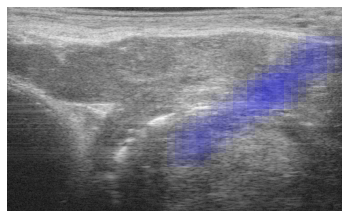

In [32]:
R = get_relevancy_matrix(out['attentions'], out['logits'][1], device='cuda')
R = np.array(R[0].mean(0).detach().cpu())
R = (R - R.min()) / (R.max() - R.min())
plot_with_relevancy_maps(bmode, pos, R)

In [33]:
from src.data.exact.splits import Splits, HasProstateMaskFilter
splits = Splits(cohort_specifier='UVA')
splits.apply_filters(HasProstateMaskFilter())
test_data = splits.get_metadata(splits.get_test())
test_data.sort_values(by='patient_specifier').to_csv('patients.csv')

In [34]:
splits = Splits

In [35]:
PATIENT = 'UVA-0211'

cores_dm.test_ds.metadata.query('patient_specifier == @PATIENT')

,patient_id,path_on_server,center,loc,grade,age,family_history,psa,pct_cancer,primary_grade,secondary_grade,patient_specifier,core_specifier
52,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,LAL,Benign,77,False,16.6,NaN,NaN,NaN,UVA-0211,UVA-0211_LAL
67,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RAL,GS7,77,False,16.6,66.0,4.0,3.0,UVA-0211,UVA-0211_RAL
68,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RAM,GS7,77,False,16.6,100.0,4.0,3.0,UVA-0211,UVA-0211_RAM
69,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RBL,GS7,77,False,16.6,64.0,4.0,3.0,UVA-0211,UVA-0211_RBL
70,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RBM,GS7,77,False,16.6,55.0,4.0,3.0,UVA-0211,UVA-0211_RBM
71,211,/med-i_data/Data/Exact_Ultrasound/data/full_da...,UVA,RML,GS7,77,False,16.6,83.0,4.0,3.0,UVA-0211,UVA-0211_RML


In [345]:
from src.data.exact.dataset import patch_view_to_core_out

from src.utils.attention_mapping import get_relevancy_matrix
from src.data.exact.transforms import TransformV3

t = TransformV3()
def core_to_model_in(core_specifier):
    core = Core(core_specifier)
    return patch_view_to_core_out(core.get_patch_view(needle_region_only=True, prostate_region_only=False, needle_intersection_threshold=0.66), t)

def get_bmode_for_core(core_specifier, size=(512, 512)): 
    return resize(to_bmode(Core(core_specifier).image), size)

def plot_with_relevancy_maps(bmode, pos, relevance, base_alpha=0.3, ax=None, thresh=0.4):
    if ax is None: 
        plt.figure()
        ax = plt.gca()

    from matplotlib.cm import get_cmap
    cm = get_cmap('viridis')

    ax.set_axis_off()
    ax.imshow(bmode, extent=(0, 46, 0, 28), cmap='gray')
    for i in range(len(pos)): 
        rel = relevance[i]
        if rel < thresh: continue
        fc = cm(rel)
        fc = 'yellow'
        alpha = base_alpha * rel
        add_patch(ax, pos[i], fc=fc, alpha=alpha)

BENIGN_REFERENCE_CORE = "UVA-0288_LBL"
benign_patch, benign_pos = core_to_model_in(BENIGN_REFERENCE_CORE)
CANCER_REFERENCE_CORE = "UVA-0515_RMM"
cancer_patch, cancer_pos = core_to_model_in(CANCER_REFERENCE_CORE)

def attach_ref(view, cancer_or_benign='cancer'):
    ref_patch = cancer_patch if cancer_or_benign == 'cancer' else benign_patch
    ref_pos = cancer_pos if cancer_or_benign == 'cancer' else benign_pos
    patch, pos = view 
    ind = np.arange(len(patch))
    new_patch = torch.concat([patch, ref_patch])
    new_pos = torch.concat([pos, ref_pos])

    return new_patch, new_pos, ind

def make_attn_heatmap(spec, cls_, ax=None, base_alpha=0.4, modifier_factor=0.8):
    view = core_to_model_in(spec)
    
    patch, pos = view
    out = model(patch.cuda(), pos[:, 0].cuda(), pos[:, 2].cuda())
    score = out['logits'].softmax(-1)[1] - best_t 
    print('score: ', score)
    print(Core(spec).metadata)

    patch, pos, ind = attach_ref(view, 'cancer' if cls_ == 1 else 'benign')
    out = model(patch.cuda(), pos[:, 0].cuda(), pos[:, 2].cuda())
    R = get_relevancy_matrix(out['attentions'], out['logits'][cls_], device='cuda').detach().cpu()
    R = np.array(R[0].mean(0))
    R = (R - R.min()) / (R.max() - R.min())

    R = R[ind]
    pos = pos[ind]

    score = score.item()
    if cls_ == 1: 
        base_alpha = base_alpha * (1 + score * modifier_factor)
    else: 
        base_alpha = base_alpha * (1 - score * modifier_factor)

    plot_with_relevancy_maps(get_bmode_for_core(spec), pos, R, ax=ax, base_alpha=base_alpha)

def plot_bmode_with_colored_needle(spec, ax=None, base_alpha=0.5):
    view = core_to_model_in(spec)
    
    patch, pos = view
    out = model(patch.cuda(), pos[:, 0].cuda(), pos[:, 2].cuda())
    score = out['logits'].softmax(-1)[1] - best_t 
    score = score.item()

    bmode = get_bmode_for_core(spec)
    needle_mask = Core(spec).needle_mask
    needle_mask = np.where(needle_mask == 0, np.nan, needle_mask) #* score.item()

    prostate_mask = Core(spec).prostate_mask
    prostate_mask = np.where(prostate_mask == 0, np.nan, prostate_mask) * 0.5

    if ax is None: 
        plt.figure()
        ax = plt.gca()
    ax.set_axis_off()

    ax.imshow(bmode, extent=(0, 46, 0, 28), cmap='gray')
    ax.imshow(needle_mask, extent=(0, 46, 0, 28), alpha=0.5, cmap='viridis')
    #ax.imshow(prostate_mask, extent=(0, 46, 0, 28), alpha=0.5, cmap='viridis', vmax=1, vmin=0)

    #from matplotlib.cm import get_cmap
    #cm = get_cmap('RdBu')
#
    #ax.set_axis_off()
    #ax.imshow(bmode, extent=(0, 46, 0, 28), cmap='gray')
    #for i in range(len(pos)): 
    #    fc = 'red' if score > 0 else 'green'
    #    alpha = base_alpha * np.abs(score)
    #    add_patch(ax, pos[i], fc=fc, alpha=alpha)


In [346]:
SUCCESS_CASES = [
    'UVA-0211_RAL',
    'UVA-0211_RAM',
    'UVA-0211_LAL',
    'UVA-0211_RBM',
    'UVA-0211_RML',
    'UVA-0211_RBL',
]

FAILURE_CASES = "UVA-0103_RAL"

score:  tensor(0.1447, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 211, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS7/UVA-0211_RBM_GS7.mat', 'center': 'UVA', 'loc': 'RBM', 'grade': 'GS7', 'age': 77, 'family_history': False, 'psa': 16.6, 'pct_cancer': 55.0, 'primary_grade': 4.0, 'secondary_grade': 3.0, 'patient_specifier': 'UVA-0211', 'core_specifier': 'UVA-0211_RBM'}
score:  tensor(0.1447, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 211, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS7/UVA-0211_RBM_GS7.mat', 'center': 'UVA', 'loc': 'RBM', 'grade': 'GS7', 'age': 77, 'family_history': False, 'psa': 16.6, 'pct_cancer': 55.0, 'primary_grade': 4.0, 'secondary_grade': 3.0, 'patient_specifier': 'UVA-0211', 'core_specifier': 'UVA-0211_RBM'}


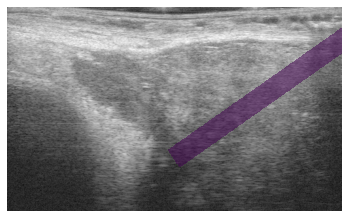

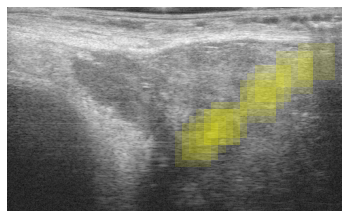

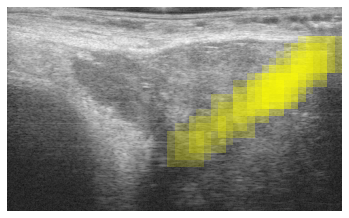

In [353]:
def plot_all(spec): 
    plot_bmode_with_colored_needle(spec)
    make_attn_heatmap(spec, cls_ = 0, base_alpha=0.3)
    make_attn_heatmap(spec, cls_ = 1, base_alpha=0.3)

plot_all(SUCCESS_CASES[3])

score:  tensor(-0.1638, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 103, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS9/UVA-0103_RAL_GS9.mat', 'center': 'UVA', 'loc': 'RAL', 'grade': 'GS9', 'age': 50, 'family_history': False, 'psa': 13.3, 'pct_cancer': 70.0, 'primary_grade': 4.0, 'secondary_grade': 5.0, 'patient_specifier': 'UVA-0103', 'core_specifier': 'UVA-0103_RAL'}
score:  tensor(-0.1638, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 103, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS9/UVA-0103_RAL_GS9.mat', 'center': 'UVA', 'loc': 'RAL', 'grade': 'GS9', 'age': 50, 'family_history': False, 'psa': 13.3, 'pct_cancer': 70.0, 'primary_grade': 4.0, 'secondary_grade': 5.0, 'patient_specifier': 'UVA-0103', 'core_specifier': 'UVA-0103_RAL'}


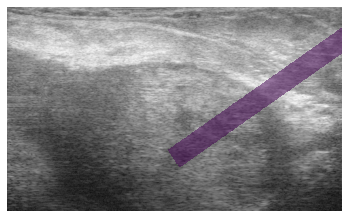

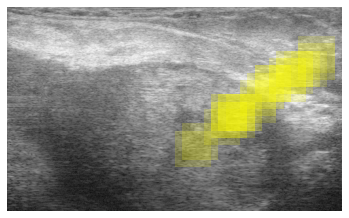

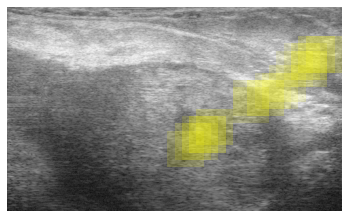

In [330]:
plot_bmode_with_colored_needle("UVA-0103_RAL")
make_attn_heatmap("UVA-0103_RAL", cls_ = 0, base_alpha=0.3)
make_attn_heatmap("UVA-0103_RAL", cls_ = 1, base_alpha=0.3)

score:  tensor(0.1576, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 211, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS7/UVA-0211_RAL_GS7.mat', 'center': 'UVA', 'loc': 'RAL', 'grade': 'GS7', 'age': 77, 'family_history': False, 'psa': 16.6, 'pct_cancer': 66.0, 'primary_grade': 4.0, 'secondary_grade': 3.0, 'patient_specifier': 'UVA-0211', 'core_specifier': 'UVA-0211_RAL'}
score:  tensor(0.1576, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 211, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS7/UVA-0211_RAL_GS7.mat', 'center': 'UVA', 'loc': 'RAL', 'grade': 'GS7', 'age': 77, 'family_history': False, 'psa': 16.6, 'pct_cancer': 66.0, 'primary_grade': 4.0, 'secondary_grade': 3.0, 'patient_specifier': 'UVA-0211', 'core_specifier': 'UVA-0211_RAL'}


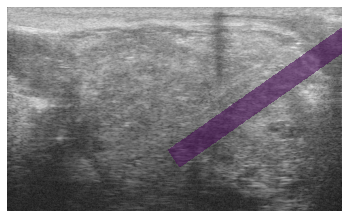

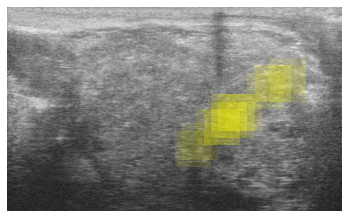

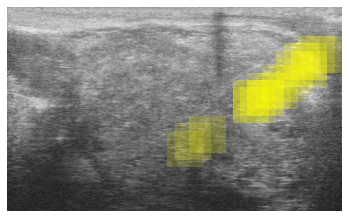

In [328]:
spec = "UVA-0211_RAL"
plot_bmode_with_colored_needle(spec)
make_attn_heatmap(spec, cls_ = 0, base_alpha=0.3)
make_attn_heatmap(spec, cls_ = 1, base_alpha=0.3)

score:  tensor(-0.0568, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 211, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/Benign/UVA-0211_LAL_Benign.mat', 'center': 'UVA', 'loc': 'LAL', 'grade': 'Benign', 'age': 77, 'family_history': False, 'psa': 16.6, 'pct_cancer': nan, 'primary_grade': nan, 'secondary_grade': nan, 'patient_specifier': 'UVA-0211', 'core_specifier': 'UVA-0211_LAL'}
score:  tensor(-0.0568, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 211, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/Benign/UVA-0211_LAL_Benign.mat', 'center': 'UVA', 'loc': 'LAL', 'grade': 'Benign', 'age': 77, 'family_history': False, 'psa': 16.6, 'pct_cancer': nan, 'primary_grade': nan, 'secondary_grade': nan, 'patient_specifier': 'UVA-0211', 'core_specifier': 'UVA-0211_LAL'}


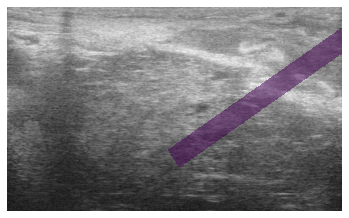

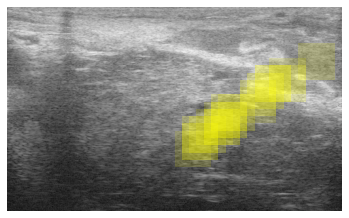

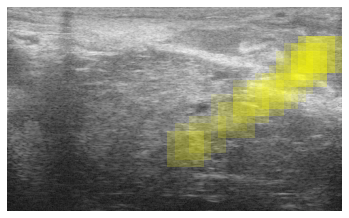

In [273]:
spec = "UVA-0211_LAL"
plot_bmode_with_colored_needle(spec)
make_attn_heatmap(spec, cls_ = 0, base_alpha=0.3)
make_attn_heatmap(spec, cls_ = 1, base_alpha=0.3)

plot_with_c

score:  tensor(-0.1370, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 103, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS9/UVA-0103_RAL_GS9.mat', 'center': 'UVA', 'loc': 'RAL', 'grade': 'GS9', 'age': 50, 'family_history': False, 'psa': 13.3, 'pct_cancer': 70.0, 'primary_grade': 4.0, 'secondary_grade': 5.0, 'patient_specifier': 'UVA-0103', 'core_specifier': 'UVA-0103_RAL'}


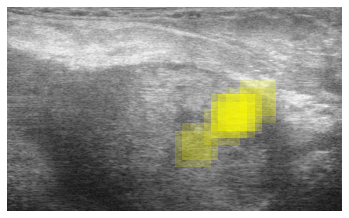

In [265]:
make_attn_heatmap("UVA-0103_RAL", cls_ = 0, base_alpha=0.3)

score:  tensor(-0.1370, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 103, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS9/UVA-0103_RAL_GS9.mat', 'center': 'UVA', 'loc': 'RAL', 'grade': 'GS9', 'age': 50, 'family_history': False, 'psa': 13.3, 'pct_cancer': 70.0, 'primary_grade': 4.0, 'secondary_grade': 5.0, 'patient_specifier': 'UVA-0103', 'core_specifier': 'UVA-0103_RAL'}


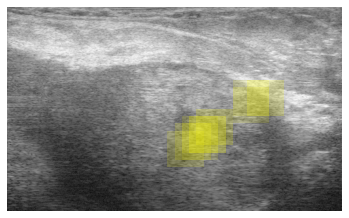

In [234]:
make_heatmap(spec = "UVA-0103_RAL", cls_=1, base_alpha=0.3)

score:  tensor(0.1465, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 211, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS7/UVA-0211_RAL_GS7.mat', 'center': 'UVA', 'loc': 'RAL', 'grade': 'GS7', 'age': 77, 'family_history': False, 'psa': 16.6, 'pct_cancer': 66.0, 'primary_grade': 4.0, 'secondary_grade': 3.0, 'patient_specifier': 'UVA-0211', 'core_specifier': 'UVA-0211_RAL'}


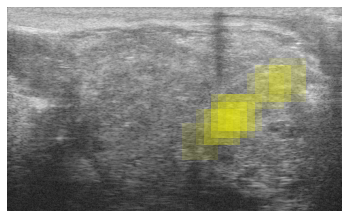

In [236]:
make_heatmap(spec = "UVA-0211_RAL", cls_=0, base_alpha=0.3)

score:  tensor(-0.1638, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 103, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS9/UVA-0103_RAL_GS9.mat', 'center': 'UVA', 'loc': 'RAL', 'grade': 'GS9', 'age': 50, 'family_history': False, 'psa': 13.3, 'pct_cancer': 70.0, 'primary_grade': 4.0, 'secondary_grade': 5.0, 'patient_specifier': 'UVA-0103', 'core_specifier': 'UVA-0103_RAL'}


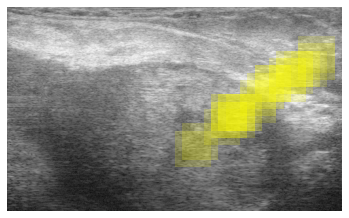

In [230]:
make_heatmap(spec = "UVA-0103_RAL", cls_=0, base_alpha=0.3)

score:  tensor(0.1465, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 211, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS7/UVA-0211_RAL_GS7.mat', 'center': 'UVA', 'loc': 'RAL', 'grade': 'GS7', 'age': 77, 'family_history': False, 'psa': 16.6, 'pct_cancer': 66.0, 'primary_grade': 4.0, 'secondary_grade': 3.0, 'patient_specifier': 'UVA-0211', 'core_specifier': 'UVA-0211_RAL'}


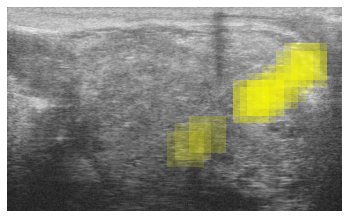

In [212]:
make_heatmap(spec = "UVA-0211_RAL", cls_=1, base_alpha=0.3)

score:  tensor(0.1465, device='cuda:0', grad_fn=<SubBackward0>)
{'patient_id': 211, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS7/UVA-0211_RAL_GS7.mat', 'center': 'UVA', 'loc': 'RAL', 'grade': 'GS7', 'age': 77, 'family_history': False, 'psa': 16.6, 'pct_cancer': 66.0, 'primary_grade': 4.0, 'secondary_grade': 3.0, 'patient_specifier': 'UVA-0211', 'core_specifier': 'UVA-0211_RAL'}


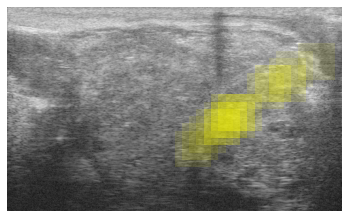

In [205]:
make_heatmap(spec = "UVA-0211_RAL", cls_=0, base_alpha=0.3)

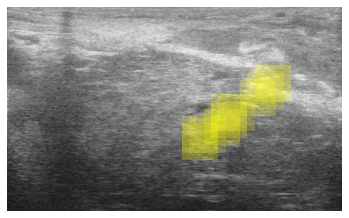

In [196]:
from src.data.exact.core import Core
spec = "UVA-0211_LAL"
core = Core(spec)

from src.data.exact.dataset import patch_view_to_core_out

from src.utils.attention_mapping import get_relevancy_matrix
from src.data.exact.transforms import TransformV3

t = TransformV3()
view = core_to_model_in(spec)
patch, pos, ind = attach_ref(view, 'cancer')

metadata = core.metadata

out = model(patch.cuda(), pos[:, 0].cuda(), pos[:, 2].cuda())
R = get_relevancy_matrix(out['attentions'], out['logits'][0], device='cuda').detach().cpu()
R = np.array(R[0].mean(0))
R = (R - R.min()) / (R.max() - R.min())

R = R[ind]
pos = pos[ind]
out['pred'] = out['logits'].softmax(-1)[1] > best_t


plot_with_relevancy_maps(get_bmode_for_core(spec), pos, R)

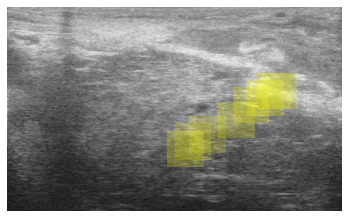

In [165]:
from src.data.exact.core import Core
spec = "UVA-0211_LAL"
core = Core(spec)

from src.data.exact.dataset import patch_view_to_core_out

from src.utils.attention_mapping import get_relevancy_matrix
from src.data.exact.transforms import TransformV3

t = TransformV3()
view = core_to_model_in(spec)
patch, pos, ind = attach_ref(view, 'benign')

metadata = core.metadata

out = model(patch.cuda(), pos[:, 0].cuda(), pos[:, 2].cuda())
R = get_relevancy_matrix(out['attentions'], out['logits'][1], device='cuda').detach().cpu()
R = np.array(R[0].mean(0))
R = (R - R.min()) / (R.max() - R.min())

R = R[ind]
pos = pos[ind]
out['pred'] = out['logits'].softmax(-1)[1] > best_t


plot_with_relevancy_maps(get_bmode_for_core(spec), pos, R)

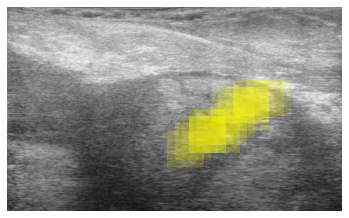

In [213]:
from src.data.exact.core import Core
spec = "UVA-0103_RMM"
core = Core(spec)

from src.data.exact.dataset import patch_view_to_core_out

from src.utils.attention_mapping import get_relevancy_matrix
from src.data.exact.transforms import TransformV3

t = TransformV3()
patch, pos = patch_view_to_core_out(core.get_patch_view(needle_region_only=True, prostate_region_only=True), t)
metadata = core.metadata

out = model(patch.cuda(), pos[:, 0].cuda(), pos[:, 2].cuda())
R = get_relevancy_matrix(out['attentions'], out['logits'][1], device='cuda').detach().cpu()
R = np.array(R[0].mean(0))
R = (R - R.min()) / (R.max() - R.min())
out['pred'] = out['logits'].softmax(-1)[1] > best_t


plot_with_relevancy_maps(get_bmode_for_core(spec), pos, R)

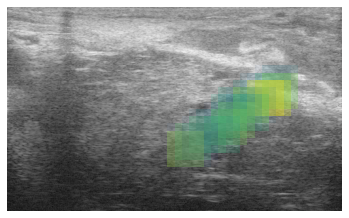

In [161]:
from src.data.exact.core import Core
spec = "UVA-0211_LAL"
core = Core(spec)

from src.data.exact.dataset import patch_view_to_core_out

from src.utils.attention_mapping import get_relevancy_matrix
from src.data.exact.transforms import TransformV3

t = TransformV3()
patch, pos = patch_view_to_core_out(core.get_patch_view(needle_region_only=True, prostate_region_only=True), t)
metadata = core.metadata

out = model(patch.cuda(), pos[:, 0].cuda(), pos[:, 2].cuda())
R = get_relevancy_matrix(out['attentions'], out['logits'][1], device='cuda').detach().cpu()
R = np.array(R[0].mean(0))
R = (R - R.min()) / (R.max() - R.min())
out['pred'] = out['logits'].softmax(-1)[1] > best_t

def get_bmode_for_core(core_specifier, size=(512, 512)): 
    return resize(to_bmode(Core(core_specifier).image), size)

def plot_with_relevancy_maps(bmode, pos, relevance, base_alpha=0.3, fc='blue', ax=None):
    if ax is None: 
        plt.figure()
        ax = plt.gca()

    from matplotlib.cm import get_cmap
    cm = get_cmap('viridis')

    ax.set_axis_off()
    ax.imshow(bmode, extent=(0, 46, 0, 28), cmap='gray')
    for i in range(len(pos)): 
        add_patch(ax, pos[i], fc=cm(relevance[i]), alpha=base_alpha*relevance[i])

plot_with_relevancy_maps(get_bmode_for_core(spec), pos, R)

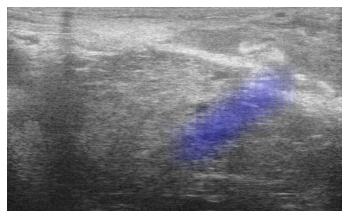

In [70]:
from src.data.exact.core import Core
spec = "UVA-0211_LAL"
core = Core(spec)

from src.data.exact.dataset import patch_view_to_core_out

from src.utils.attention_mapping import get_relevancy_matrix
from src.data.exact.transforms import TransformV3

t = TransformV3()
patch, pos = patch_view_to_core_out(core.get_patch_view(needle_region_only=True, prostate_region_only=True), t)
metadata = core.metadata

out = model(patch.cuda(), pos[:, 0].cuda(), pos[:, 2].cuda())
R = get_relevancy_matrix(out['attentions'], out['logits'][1], device='cuda').detach().cpu()
out['pred'] = out['logits'].softmax(-1)[1] > best_t

def get_bmode_for_core(core_specifier, size=(512, 512)): 
    return resize(to_bmode(Core(core_specifier).image), size)

def plot_with_relevancy_maps(bmode, pos, relevance, base_alpha=0.1, fc='blue', ax=None):
    if ax is None: 
        plt.figure()
        ax = plt.gca()

    ax.set_axis_off()
    ax.imshow(bmode, extent=(0, 46, 0, 28), cmap='gray')
    for i in range(len(pos)): 
        add_patch(ax, pos[i], fc=fc, alpha=base_alpha*relevance[i])

R = np.array(R[0].mean(0)) * 10

plot_with_relevancy_maps(get_bmode_for_core(spec), pos, R)

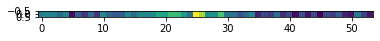

In [55]:
plt.imshow(R.mean(1))

In [52]:
R[0].mean(0)

tensor([0.0187, 0.0187, 0.0187, 0.0186, 0.0187, 0.0186, 0.0186, 0.0186, 0.0186,
        0.0186, 0.0187, 0.0186, 0.0186, 0.0186, 0.0187, 0.0186, 0.0187, 0.0187,
        0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0186, 0.0188, 0.0187,
        0.0187, 0.0187, 0.0187, 0.0186, 0.0186, 0.0186, 0.0186, 0.0187, 0.0186,
        0.0186, 0.0186, 0.0186, 0.0186, 0.0186, 0.0186, 0.0186, 0.0186, 0.0186,
        0.0186, 0.0186, 0.0186, 0.0186, 0.0186, 0.0186, 0.0187, 0.0186, 0.0186])

In [39]:
metadata

{'patient_id': 211,
 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/GS7/UVA-0211_RAM_GS7.mat',
 'center': 'UVA',
 'loc': 'RAM',
 'grade': 'GS7',
 'age': 77,
 'family_history': False,
 'psa': 16.6,
 'pct_cancer': 100.0,
 'primary_grade': 4.0,
 'secondary_grade': 3.0,
 'patient_specifier': 'UVA-0211',
 'core_specifier': 'UVA-0211_RAM'}

In [ ]:
R.shape

torch.Size([1, 55, 55])

In [ ]:
label

False

In [ ]:
model(patch.cuda(), pos[:, 0].cuda(), pos[:, 2].cuda())['logits'].softmax(-1)

tensor([0.3148, 0.6852], device='cuda:0', grad_fn=<SoftmaxBackward0>)